<a href="https://colab.research.google.com/github/elvinasari/pneumonia-with-cnn/blob/main/Load_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/ModelCNN/VGG16/model_vgg16_1.h5')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import cv2
from PIL import Image
import random
import glob
from sklearn.model_selection import train_test_split
import shutil

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sesuaikan ukuran dengan input model (misalnya 224x224 untuk VGG16)
img_size = (224, 224)
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/chest_xray_dataset/split/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 587 images belonging to 2 classes.


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi probabilitas
y_pred_probs = model.predict(test_generator)

# Ubah ke kelas 0 dan 1
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Label asli
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/19 ━━━━━━━━━━━━━━━━━━━━ 2:39 18s/step

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediksi: PNEUMONIA (99.99%)


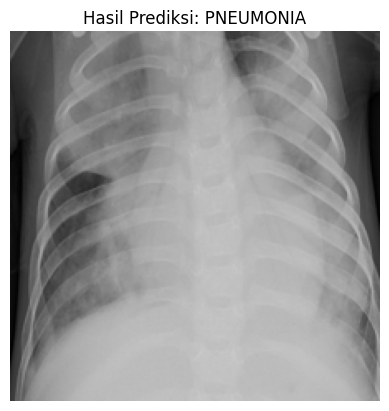

In [ ]:
# Path ke model dan gambar
model_path = '/content/drive/MyDrive/ModelCNN/VGG16/model_vgg16_1.h5'
image_path = '/content/drive/MyDrive/dataset for grad-cam/person7_bacteria_25.jpeg'  # ganti sesuai gambar

# Load model
model = load_model(model_path)

# Ukuran gambar yang sesuai
IMG_SIZE = (224, 224)

# Load dan preprocess gambar
img = Image.open(image_path).convert('RGB').resize(IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_batch = np.expand_dims(img_array, axis=0)

# Prediksi
prediction = model.predict(img_batch)[0][0]

# Tampilkan hasil
label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
confidence = prediction if prediction > 0.5 else 1 - prediction

print(f"Prediksi: {label} ({confidence*100:.2f}%)")

# Tampilkan citra
plt.imshow(img)
plt.title(f"Hasil Prediksi: {label}")
plt.axis('off')
plt.show()

In [ ]:
def get_gradcam(model, img_batch, cam_type='pneumonia',
                layer_name='block5_conv3'):
    """
    Menghasilkan heat‑map Grad‑CAM.
    cam_type : 'pneumonia' | 'normal'
    img_batch : array shape (1,224,224,3) bernilai 0‑1
    """
    grad_model = tf.keras.Model(inputs=model.inputs,
                                outputs=[model.get_layer(layer_name).output,
                                         model.output])

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_batch)     # forward pass
        p = preds[:, 0]                             # sigmoid → Prob. Pneumonia
        loss = p if cam_type == 'pneumonia' else (1.0 - p)

    grads   = tape.gradient(loss, conv_out)[0]      # ∂loss/∂A^k
    fmap    = conv_out[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))    # α_k

    cam = np.zeros(fmap.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[:, :, i]

    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)                  # skala 0‑1
    cam = cv2.resize(cam, IMG_SIZE)
    return cam

In [ ]:
def predict_image(img_path, cam_type='pneumonia',
                  save_to_drive=False, drive_dir='/content/drive/MyDrive/ModelCNN/Prediksi_Load_Model'):
    """
    cam_type  : 'pneumonia' (positive) | 'normal' (negative)
    """
    # 1. Load & preprocess
    pil_img   = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    arr_norm  = tf.keras.preprocessing.image.img_to_array(pil_img)/255.0
    arr_batch = np.expand_dims(arr_norm, 0)

    # 2. Prediksi
    prob = float(model.predict(arr_batch, verbose=0)[0][0])
    pred_label = 'PNEUMONIA' if prob > 0.5 else 'NORMAL'

    # 3. Grad‑CAM sesuai cam_type
    heat = get_gradcam(model, arr_batch, cam_type=cam_type)
    heat_uint8 = np.uint8(255 * heat)
    heat_color = cv2.applyColorMap(heat_uint8, cv2.COLORMAP_JET)

    # 4. Overlay
    img_bgr   = cv2.cvtColor(np.uint8(pil_img), cv2.COLOR_RGB2BGR)
    overlay   = cv2.addWeighted(img_bgr, 0.6, heat_color, 0.4, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    # 5. Tampilkan
    plt.figure(figsize=(4,4))
    plt.imshow(overlay_rgb)
    plt.title(f"{pred_label} (p={prob:.2f})  |  CAM: {cam_type}")
    plt.axis('off')
    plt.show()

    # 6. Simpan (opsional)
    if save_to_drive:
        import os, pathlib
        pathlib.Path(drive_dir).mkdir(parents=True, exist_ok=True)
        fname = f"{pathlib.Path(img_path).stem}_{cam_type}_{pred_label}_p{prob:.2f}.png"
        cv2.imwrite(os.path.join(drive_dir, fname), cv2.cvtColor(overlay_rgb, cv2.COLOR_RGB2BGR))
        print("🗂️  Disimpan :", fname)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


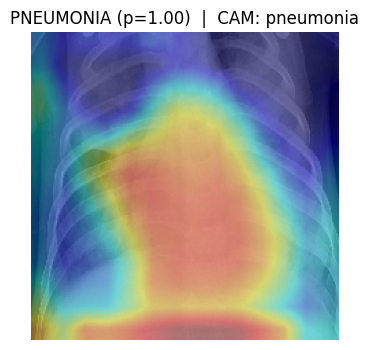

🗂️  Disimpan : person7_bacteria_25_pneumonia_PNEUMONIA_p1.00.png


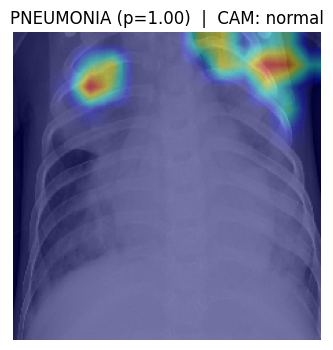

🗂️  Disimpan : person7_bacteria_25_normal_PNEUMONIA_p1.00.png


In [ ]:
img_path = '/content/drive/MyDrive/dataset for grad-cam/person7_bacteria_25.jpeg'

# Heat‑map bukti PNEUMONIA
predict_image(img_path, cam_type='pneumonia', save_to_drive=True)

# Heat‑map bukti NORMAL (negatif)
predict_image(img_path, cam_type='normal',    save_to_drive=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
Prediksi: PNEUMONIA (99.99%)


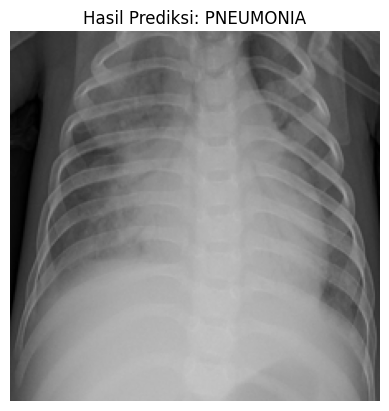

In [ ]:
image_path = '/content/drive/MyDrive/dataset for grad-cam/person7_bacteria_28.jpeg'  # ganti sesuai gambar

# Load model
model = load_model(model_path)

# Ukuran gambar yang sesuai
IMG_SIZE = (224, 224)

# Load dan preprocess gambar
img = Image.open(image_path).convert('RGB').resize(IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_batch = np.expand_dims(img_array, axis=0)

# Prediksi
prediction = model.predict(img_batch)[0][0]

# Tampilkan hasil
label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
confidence = prediction if prediction > 0.5 else 1 - prediction

print(f"Prediksi: {label} ({confidence*100:.2f}%)")

# Tampilkan citra
plt.imshow(img)
plt.title(f"Hasil Prediksi: {label}")
plt.axis('off')
plt.show()

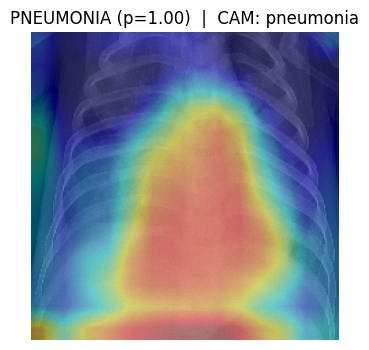

🗂️  Disimpan : person7_bacteria_28_pneumonia_PNEUMONIA_p1.00.png


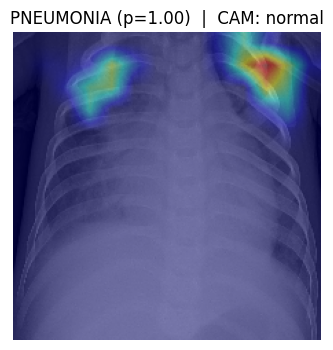

🗂️  Disimpan : person7_bacteria_28_normal_PNEUMONIA_p1.00.png


In [ ]:
img_path = '/content/drive/MyDrive/dataset for grad-cam/person7_bacteria_28.jpeg'

# Heat‑map bukti PNEUMONIA
predict_image(img_path, cam_type='pneumonia', save_to_drive=True)

# Heat‑map bukti NORMAL (negatif)
predict_image(img_path, cam_type='normal',    save_to_drive=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediksi: NORMAL (96.32%)


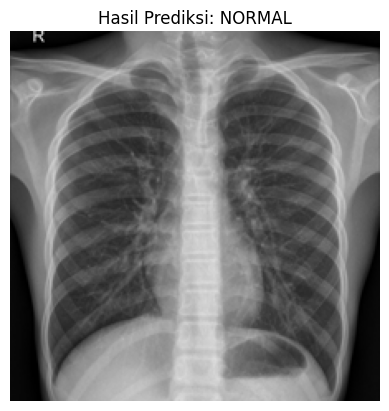

In [ ]:
image_path = '/content/drive/MyDrive/dataset for grad-cam/IM-0041-0001.jpeg'  # ganti sesuai gambar

# Load model
model = load_model(model_path)

# Ukuran gambar yang sesuai
IMG_SIZE = (224, 224)

# Load dan preprocess gambar
img = Image.open(image_path).convert('RGB').resize(IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_batch = np.expand_dims(img_array, axis=0)

# Prediksi
prediction = model.predict(img_batch)[0][0]

# Tampilkan hasil
label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
confidence = prediction if prediction > 0.5 else 1 - prediction

print(f"Prediksi: {label} ({confidence*100:.2f}%)")

# Tampilkan citra
plt.imshow(img)
plt.title(f"Hasil Prediksi: {label}")
plt.axis('off')
plt.show()

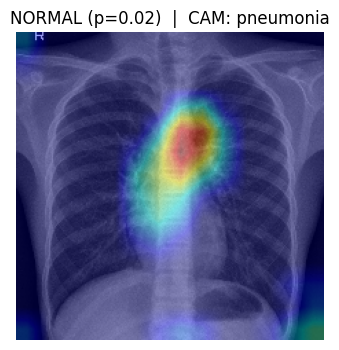

🗂️  Disimpan : IM-0041-0001_pneumonia_NORMAL_p0.02.png


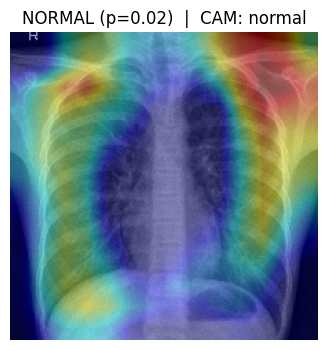

🗂️  Disimpan : IM-0041-0001_normal_NORMAL_p0.02.png


In [ ]:
img_path = '/content/drive/MyDrive/dataset for grad-cam/IM-0041-0001.jpeg'

# Heat‑map bukti PNEUMONIA
predict_image(img_path, cam_type='pneumonia', save_to_drive=True)

# Heat‑map bukti NORMAL (negatif)
predict_image(img_path, cam_type='normal',    save_to_drive=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediksi: NORMAL (99.24%)


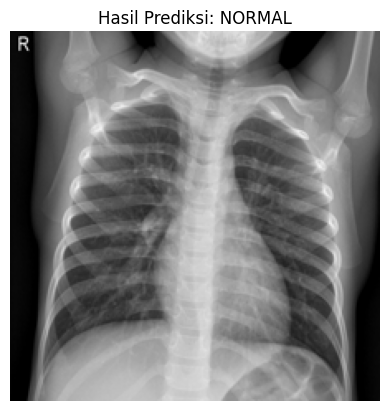

In [ ]:
image_path = '/content/drive/MyDrive/dataset for grad-cam/IM-0063-0001.jpeg'  # ganti sesuai gambar

# Load model
model = load_model(model_path)

# Ukuran gambar yang sesuai
IMG_SIZE = (224, 224)

# Load dan preprocess gambar
img = Image.open(image_path).convert('RGB').resize(IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_batch = np.expand_dims(img_array, axis=0)

# Prediksi
prediction = model.predict(img_batch)[0][0]

# Tampilkan hasil
label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
confidence = prediction if prediction > 0.5 else 1 - prediction

print(f"Prediksi: {label} ({confidence*100:.2f}%)")

# Tampilkan citra
plt.imshow(img)
plt.title(f"Hasil Prediksi: {label}")
plt.axis('off')
plt.show()

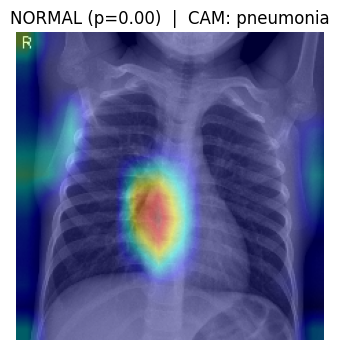

🗂️  Disimpan : IM-0063-0001_pneumonia_NORMAL_p0.00.png


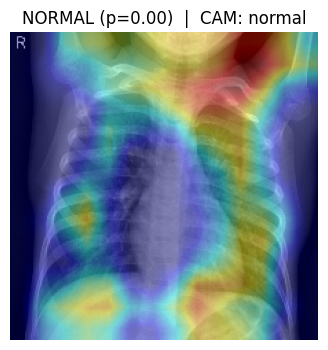

🗂️  Disimpan : IM-0063-0001_normal_NORMAL_p0.00.png


In [ ]:
img_path = '/content/drive/MyDrive/dataset for grad-cam/IM-0063-0001.jpeg'

# Heat‑map bukti PNEUMONIA
predict_image(img_path, cam_type='pneumonia', save_to_drive=True)

# Heat‑map bukti NORMAL (negatif)
predict_image(img_path, cam_type='normal',    save_to_drive=True)